# Basic VAE

References:

Auto-Encoding Variational Bayes (Kingma and Welling 2013) https://arxiv.org/abs/1312.6114

Variational Inference monograph from Michael Jordan https://people.eecs.berkeley.edu/~jordan/papers/variational-intro.pdf

Stanford Notes (Stefano Ermon): https://ermongroup.github.io/cs228-notes/inference/variational/

There are much more modern VAE variants used for NN-based compression nowadays. In particular, vector-quantized (VQ-VAE) is widely used because it discretizes the latent space and can learn high-frequency features. For open-source implementations, check out https://github.com/AntixK/PyTorch-VAE

This notebook aims to provide a basic introduction to the concept, with a minimal but effective implementation


##Variational Inference

We start from the observation that maximum likelihood estimation (MLE) is equivalent to minimizing the Kullback-Leibler (KL) Divergence (also known as relative entropy) between the true distribution and the likelihood

$
\mathbb{E}_{x \sim p(\cdot)} [\log p_{\theta} (x)] = - H(p) - D_{KL} (p || p_{\theta} )
$

Bayesian perspective: latent variable model

$
p(x) = \int p(x|z) p(z) dz
$

We could write

$
\log p_{\theta}(x) = \log \int p_{\theta} (x|z) p(z) dz
$

But this is computationally intractable because it's impossible to know all possible latent variables $z_{i}$.

Instead, we consider pairs of $(x, z)$ jointly, by sampling $z \sim p(z | x_{i})$.

$
\theta \leftarrow arg\,max \sum\limits_{i=1}^{N} \mathbb{E}_{z \sim p (z | x_{i})} [\log p_{\theta} (x_{i}, z)]
$

But how can we get $p_{\theta} (z|x_{i})$?

We must make it a learned function, and further approximate with $q_{\phi} (z|x) \approx p_{\theta}(z|x)$

This is known as "Amortized Inference" and specifically, this is our encoder. As we will see later, the simplest way to make this tractable is to make an assumption of normality (that it's Gaussian). There is a vast body of literature on this sort of thing, and we've swept a lot under the rug.










##ELBO

$
\log p_{\theta}(x) = \log \int p_{\theta} (x|z) p(z) dz = \log \int \frac{q_{\phi} (z|x)}{q_{\phi} (z|x)} p_{\theta}(x,z)dz = \log \mathbb{E}_{z \sim q_{\phi}(z|x)}\left[\frac{p_{\theta}(x,z)}{q_{\phi}(z|x)}\right] \geq \mathbb{E}_{z \sim q_{\phi}(z|x)}\left[\log \frac{p_{\theta}(x,z)}{q_{\phi}(z|x)}\right] \equiv ELBO
$

Where the last inequality is by Jensen's inequality, and ELBO stands for "Evidence Lower Bound." This is the heart of many Variational Bayesian Inference applications.

Alternatively, from the perspective of variationally optimizing the amortized inference distribution, we can derive ELBO as follows:

$D_{KL} (q_{\phi}(z|x) || p_{\theta}(z|x)) = \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \frac{q_{\phi}(z|x)}{p_{\theta}(x|z)} \right] = \log p_{\theta}(x) + \mathbb{E}_{z \sim q_{\phi}(z|x)} \left[ \log \frac{q_{\phi}(z|x)}{p_{\theta}(x,z)} \right] = \log p_{\theta}(x) - ELBO$

And this also sheds light on the question: how tight is ELBO? - it depends on the amortized inference.

We can also write ELBO in another useful form, often used in practice:

$ELBO = \mathbb{E}_{z \sim q_{\phi}(z|x)}[\log p_{\theta}(x|z) + \log p_{\theta}(z)] + H(q_{\phi}) = -D_{KL} [q_{\phi}(z|x) || p_{\theta} (z)] + \mathbb{E}_{z \sim q_{\phi}(z|x)} [\log p_{\theta} (x|z)] = H(q_{\phi}(z|x), p_{\theta}(x|z)) - D_{KL} [q_{\phi}(z|x) || p_{\theta} (z)]$

So we end up with a cross entropy term (reconstruction loss) and a KL Divergence term

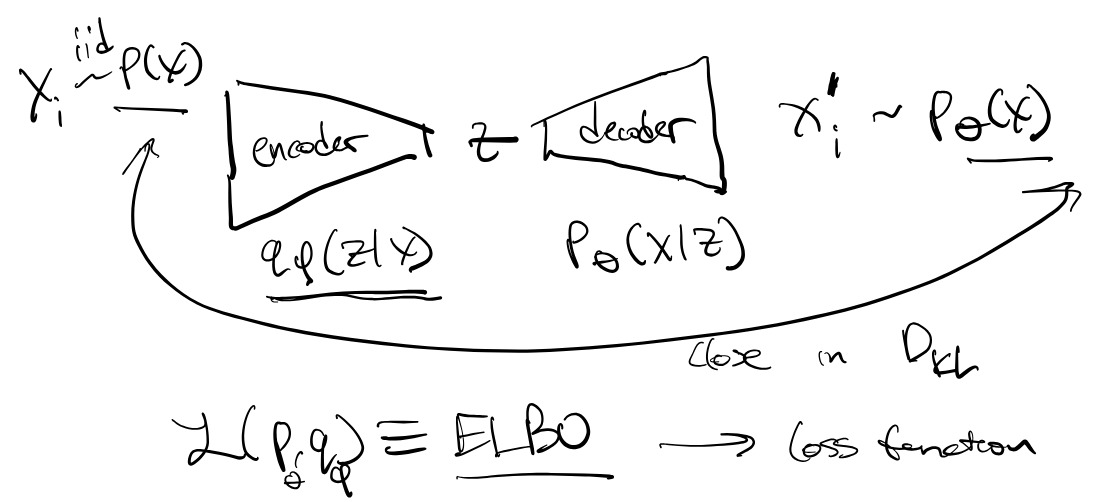

So now, our MLE program goes from:

$
\theta \leftarrow arg\,max \frac{1}{N} \sum\limits_{i}^{N} \log p_{\theta}(x_{i})
$ (intractable)

To

$
\theta, \phi \leftarrow arg\,max \frac{1}{N} \sum\limits_{i}^{N} \mathcal{L}_{i} (p_{\theta}, q_{\phi})
$ (maximize ELBO)

We do gradient descent to compute the gradient updates:

For each $x_{i}$ or minibatch:


> Compute: $\nabla_{\theta} \mathcal{L} (p_{\theta}(x_{i}|z), q_{\phi} (z|x_{i}))$
> > Sample $z \sim q_{\phi}(z|x_{i})$    
> > $\nabla_{\theta} \mathcal{L} \approx \nabla_{\theta} \log p_{\theta} (x_{i}|z)$

> Compute $\nabla_{\phi} \mathcal{L} = ???$

> $\theta \leftarrow \theta + \alpha \nabla_{\theta} \mathcal{L}$

> $\phi \leftarrow \theta + \alpha \nabla_{\phi} \mathcal{L}$

Where $\alpha$ is the learning rate

## Reparameterization Trick

BUT the problem is that we cannot compute $\nabla_{\phi} \mathcal{L}$ !!!

To see, this, we write:

$
\nabla_{\phi} \mathcal{L} = \nabla_{\phi} \mathbb{E}_{z \sim q_{\phi}(z|x_{i})} [\log p_{\theta}(x_{i}|z) + \log p(z)] + \nabla_{\phi} H(q_{\phi} (z|x_{i}))
$

The second term in the above expression goes away because the entropy is just some constant. The troublesome part is the first term. We cannot backpropagate through a stochastic node!

$
\nabla_{\theta} \mathbb{E}_{p_{\theta}(x)} [f(x)] \neq \mathbb{E}_{p_{\theta}(x)} [\nabla_{\theta} f(x)]
$

So, a straightforward solution to this problem is to use the "Reparameterization Trick" which is essentially a normality (Gaussianity) assumption on the amorized inference distribution (the encoder)

$z = \mu_{\phi} (x) + \epsilon \Sigma_{\phi}(x), \: \epsilon \sim \mathcal{N}(0, I) $





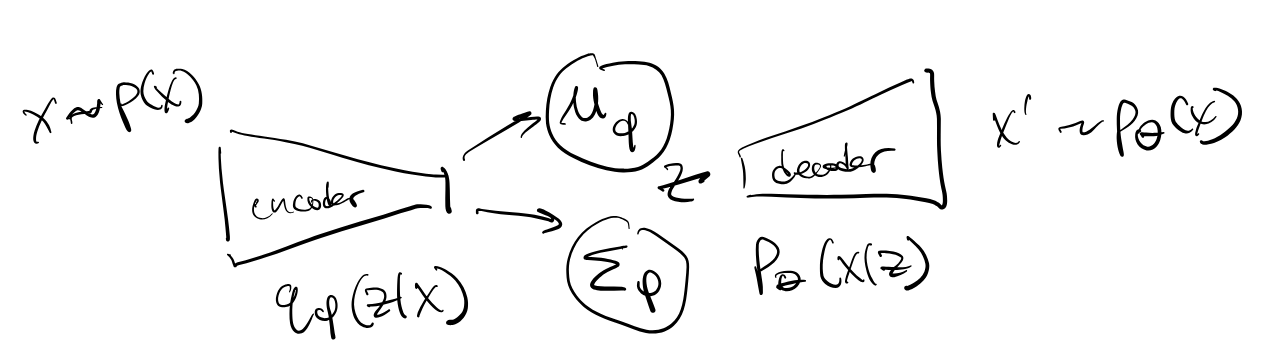

# Implementation

### Imports and Settings

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import time

In [2]:
# Set random seeds. We do this so that we can, in principle, reproduce results by "controlling" the pseudorandomness generation
# But warning: in some cases, Python pseudorandom number generator (PRNG) can be unreliable w.r.t its reproducibility
# i.e. when parallelizing a system, centralized state-based models for PRNG (as done below) start to yield inconsistent results
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [3]:
# Set the device. Default to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Plotting Utils

In [4]:
# Display MNIST images
def display_images(x, n_rows=4, n_cols=4, img_size=1, title=None):
    # plot generated data (outputed MNIST images)
    x = x.data.cpu().view(-1, 28, 28)
    plt.figure(figsize=(img_size * n_cols, img_size * n_rows))
    plt.suptitle(title, color='k', fontsize=16, y=1.06)
    for row_i in range(n_rows):
        for i in range(n_cols):
            image_i = (row_i * n_cols) + i + 1
            ax = plt.subplot(n_rows, n_cols, image_i)
            plt.imshow(x[image_i - 1], cmap='gray_r') # zero-indexed
            ax.set_aspect('equal')
            plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.show()

### Load Data

In [5]:
# Note that pixel balues of MNIST images are normalized to range [0, 1]

# download and transform train dataset
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data',
                                                          download=True,
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                          ])),
                                           batch_size=256,
                                           drop_last=True,
                                           shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data',
                                                          download=True,
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                          ])),
                                           batch_size=256,
                                           drop_last=True,
                                           shuffle=True)

In [6]:
train_images, train_labels = next(iter(train_loader))

sample_image, sample_label = train_images[0], train_labels[0]

print(sample_image.size())
print(sample_image.shape[1]*sample_image.shape[2])

torch.Size([1, 28, 28])
784


## **Variational Autoencoder**
## Notes:

1. Define the encoder and decoder in the VAE module.

  i) Build an encoder with Linear and RELU layers. For the last linear layer of encoder, define the output to be of size *2d*, of which the first *d* values are the means and the remaining *d* values are the variances.

  ii)We sample *z∈ $R^{d}$* using these means and variances as per the reparameterisation trick **z=E(z)+ϵ⊙√V(z)**
  where ϵ∼N(0,$I_{d}$)

  iii)For decoder, mirror the architecture. For the last linear layer in the decoder, use the sigmoid activation so that we can have output in range [0, 1], similar to the input data.

2. For the reparameterise function, compute the standard deviation (std) from log variance (logvar). Use log variance instead of variance because we want to make sure the variance is non-negative, and taking the log of it ensures that we have the full range of the variance, which makes the training more stable.

3. For the forward function, compute the mu (first half) and logvar (second half) from the encoder, then compute the *z* via the reparameterise function. Finally, return the output of the decoder.

In [7]:
# Defining the model
d = 20
input_dim = 784 # 28*28 ... or, number of pixels in each MNIST image

# h_dims = [512, 256]

class VAE(nn.Module):
    def __init__(self, input_dim, h1_dim, h2_dim, z_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        # encoder layers
        self.fc1 = nn.Linear(input_dim, h1_dim)
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        # layer for mean
        self.fc3_mu = nn.Linear(h2_dim, z_dim)
        # layer for log variance
        self.fc3_logvar = nn.Linear(h2_dim, z_dim)

        # decoder layers
        self.fc4 = nn.Linear(z_dim, h2_dim)
        self.fc5 = nn.Linear(h2_dim, h1_dim)
        self.fc6 = nn.Linear(h1_dim, input_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        # essentially splits latent code into two parts:
        # first part for mean...
        mu = self.fc3_mu(h)
        # second part for log variance
        logvar = self.fc3_logvar(h)
        return mu, logvar

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        # sigmoid activation for reconstruction xhat ensures probability [0,1]
        return F.sigmoid(self.fc6(h))

    def reparameterise(self, mu, logvar):
        '''
        Reparameterization trick: use samples from N(0, 1) to sample from N(mu, var)
        '''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        # encode input image
        mu, logvar = self.encoder(x.view(-1, self.input_dim))
        # reparameterization trick
        z = self.reparameterise(mu, logvar)
        # decode latent code into output (generated) image
        xhat = self.decoder(z)
        return xhat, mu, logvar

In [8]:
# Construct VAE model
model = VAE(input_dim=input_dim, h1_dim=512, h2_dim=256, z_dim=d).to(device)

In [9]:
from torchsummary import summary
summary(model, (28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 256]         131,328
            Linear-3                   [-1, 20]           5,140
            Linear-4                   [-1, 20]           5,140
            Linear-5                  [-1, 256]           5,376
            Linear-6                  [-1, 512]         131,584
            Linear-7                  [-1, 784]         402,192
Total params: 1,082,680
Trainable params: 1,082,680
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 4.13
Estimated Total Size (MB): 4.15
----------------------------------------------------------------


In [10]:
# # for more detailed peek into model parameters
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

# print(model.parameters())

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

1082680


In [11]:
# set learning rate
learning_rate = 1e-3

# build Adam optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [12]:
# Note: there are many Adam optimizer parameters to play with
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.001,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}]}

Reconstruction Loss

Cross Entropy: $H(p, q) = - \sum_{x \in \mathcal{X}} p(x) \log q(x)$

We will use the torch functional form of BCELoss, defined here: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss

$D_{KL} (\mathcal{N} (\mu, \sigma^2) \mid \mid \mathcal{N} (0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2} = -0.5 (1 + \log \sigma^2 - \sigma^2 - \mu^2)$

In [13]:
# Reconstruction + beta * KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar, beta=1):
    '''
    beta is hyperparameter we can use to weigh D_KL loss term
    '''
    # binary cross-entropy
    bce_loss = F.binary_cross_entropy(x_hat, x.view(-1, input_dim), reduction='sum')
    # KL divergence loss
    kld_loss = -0.5 * torch.sum(1 + logvar - logvar.exp() - mu**2)
    return bce_loss + beta * kld_loss

### Train
Now, we train our VAE model using MNIST

====> Test loss: 542.6419
====> Epoch: 1 Average train loss: 198.6585
====> Test loss: 160.1502
====> Epoch: 2 Average train loss: 143.5970
====> Test loss: 131.5804
====> Epoch: 3 Average train loss: 126.4089
====> Test loss: 120.9595
====> Epoch: 4 Average train loss: 119.0689
====> Test loss: 115.5656
====> Epoch: 5 Average train loss: 114.8786
====> Test loss: 112.3046
====> Epoch: 6 Average train loss: 111.9135
====> Test loss: 110.0687
====> Epoch: 7 Average train loss: 109.8161
====> Test loss: 108.1675
====> Epoch: 8 Average train loss: 108.2326
====> Test loss: 106.9488
====> Epoch: 9 Average train loss: 107.0512
====> Test loss: 105.9104
====> Epoch: 10 Average train loss: 106.1159
====> Test loss: 105.3167
====> Epoch: 11 Average train loss: 105.3335
====> Test loss: 104.6914
====> Epoch: 12 Average train loss: 104.6853
====> Test loss: 104.0469
====> Epoch: 13 Average train loss: 104.0993
====> Test loss: 103.7665
====> Epoch: 14 Average train loss: 103.6275
====> Test loss

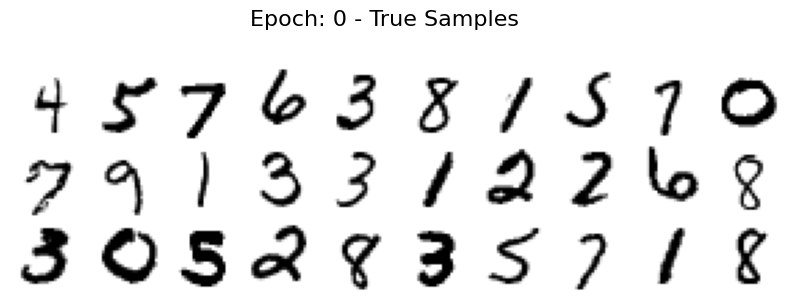

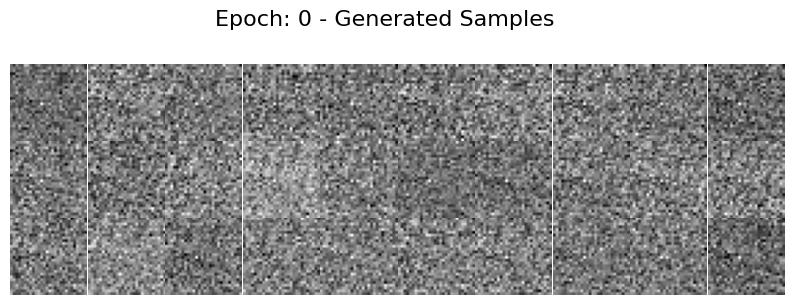

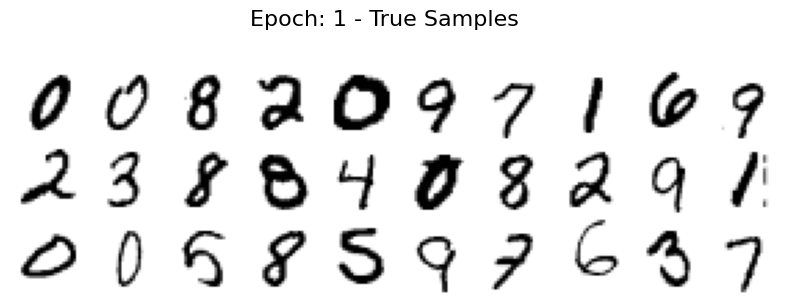

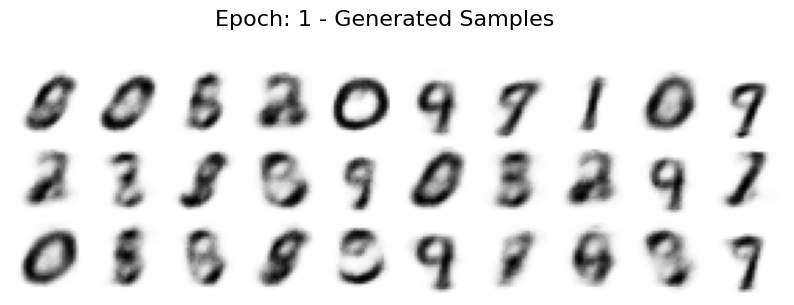

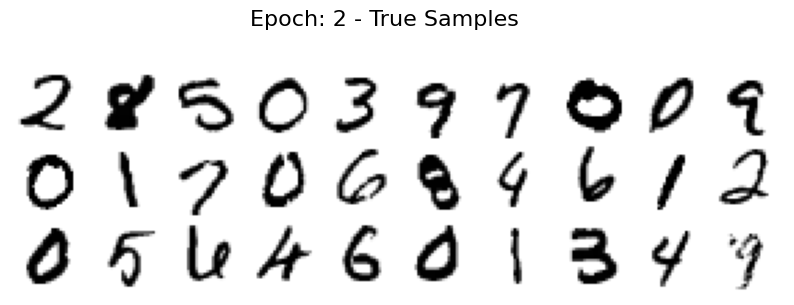

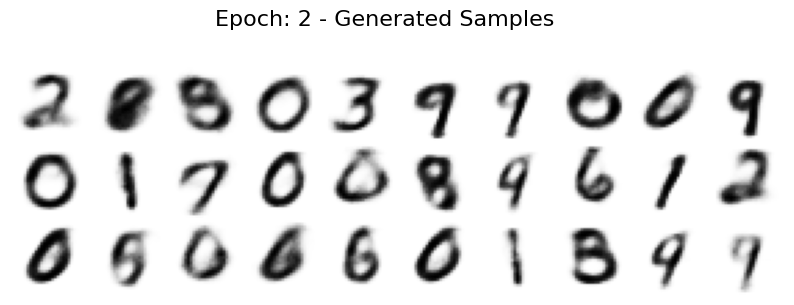

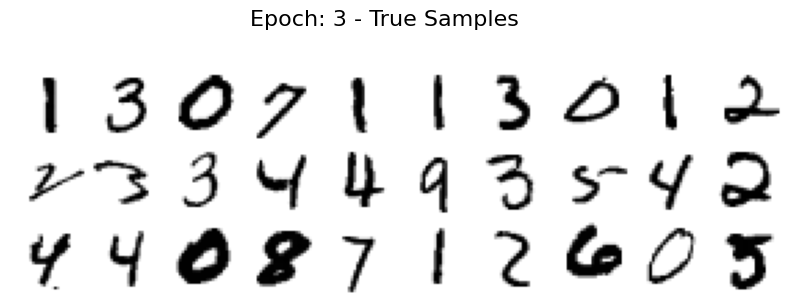

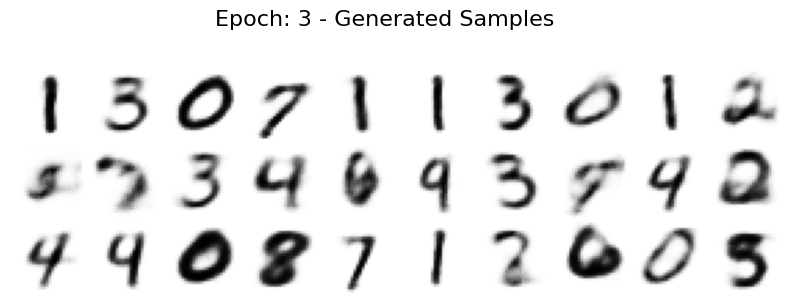

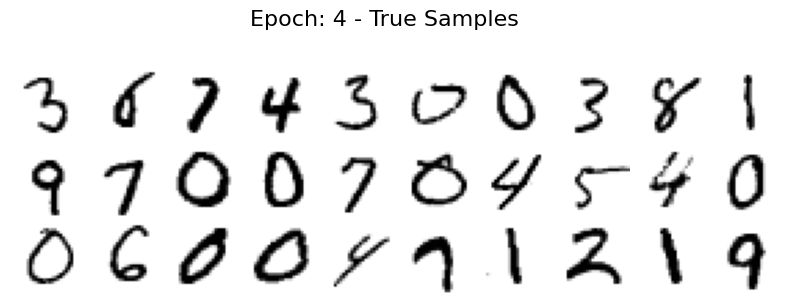

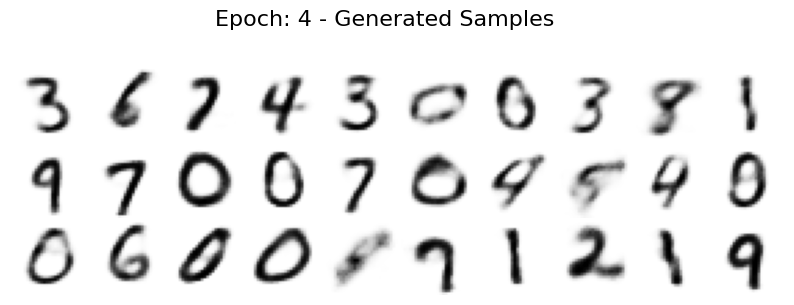

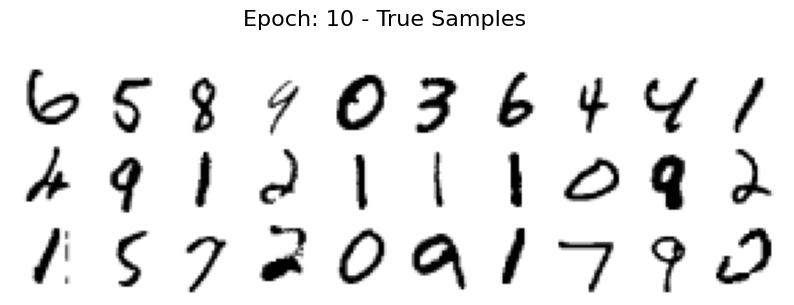

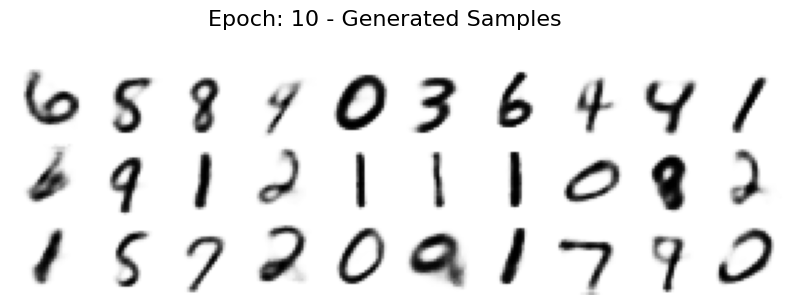

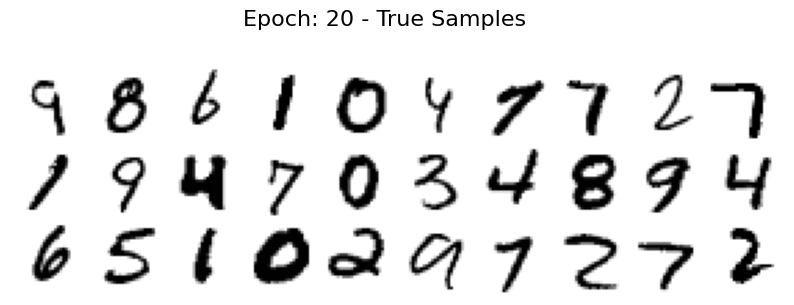

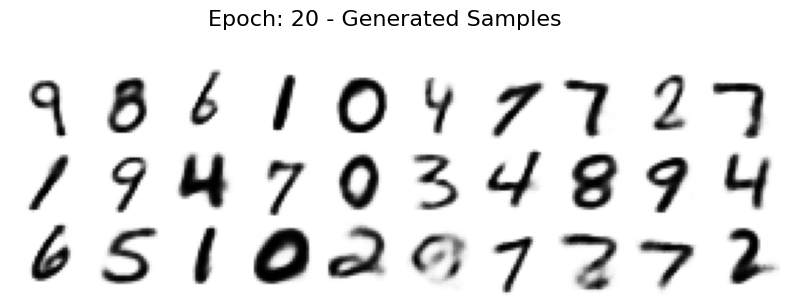

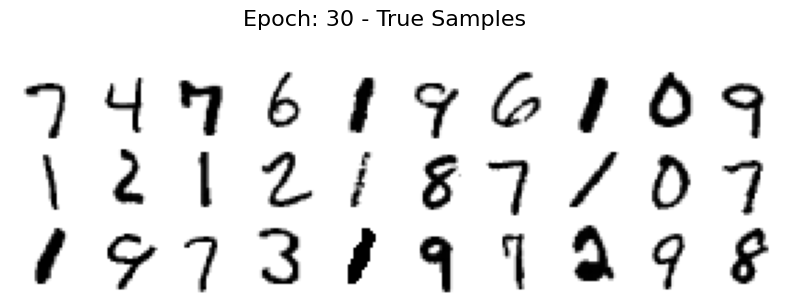

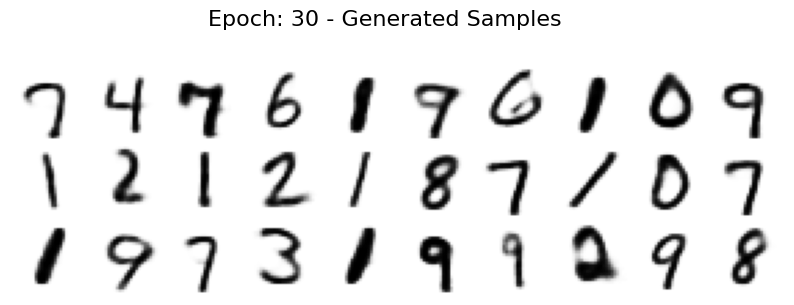

In [14]:
%%time

# Train and Test loops
# TODO: plot train and test losses
epochs = 30

# # optional: set learning rate scheduler
# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
# T_0 = 10
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0, T_mult=1)
# iters = len(train_loader)

# create dict (hashmap) to store learned means, log variances, and labels
codes = dict(mus=[], logvars=[], y=[])
train_losses = []
test_losses = []

for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for i, (x, _) in enumerate(train_loader):
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # scheduler.step(epoch + i / iters)

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        print(f'====> Epoch: {epoch} Average train loss: {avg_train_loss:.4f}')

    # Testing
    means, logvars, labels = [], [], []
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()

            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())

    codes['mus'].append(torch.cat(means))
    codes['logvars'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(f'====> Test loss: {test_loss:.4f}')

    if epoch < 5 or epoch % 10 == 0:
        display_images(x, n_rows=3, n_cols=10, title=f'Epoch: {epoch} - True Samples')
        display_images(x_hat, n_rows=3, n_cols=10, title=f'Epoch: {epoch} - Generated Samples')

### Visualize Loss Curves

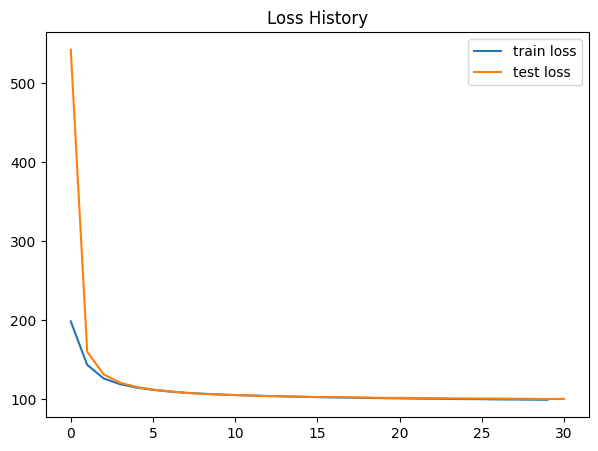

In [15]:
plt.figure(figsize=(7, 5))
plt.title("Loss History")
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()

### Visualize Generated Images

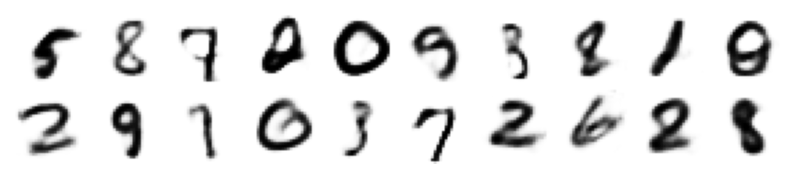

In [44]:
# Generating a few samples
N = 20
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(sample, n_rows=2, n_cols=10)

### Visualize True Images

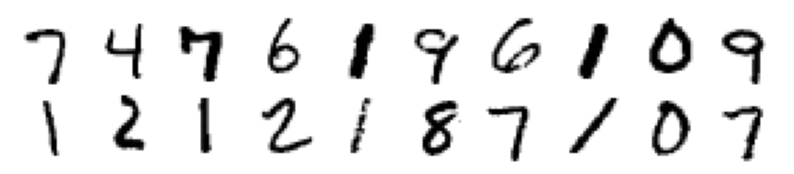

In [17]:
# Display last test batch
display_images(x, n_rows=2, n_cols=10)

## Interpolation Experiments

true sample, interpolation endpoints


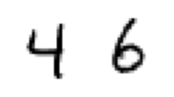

generated sample, interpolation endpoints


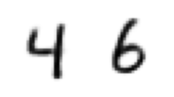

In [40]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 3
true_sample = torch.concat((x[A], x[B]), 0)
gen_sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0)) #.reshape(-1,28,28)
print("true sample, interpolation endpoints")
display_images(true_sample, n_rows=1, n_cols=2)
plt.show()
print("generated sample, interpolation endpoints")
display_images(gen_sample, n_rows=1, n_cols=2)

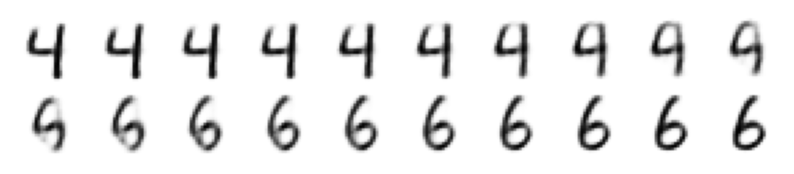

In [41]:
# Perform an interpolation between input A and B, in N steps
N = 20
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(sample, n_rows=2, n_cols=10)

In [20]:
# def set_default(figsize=(20, 10), dpi=100):
#     plt.style.use(['dark_background', 'bmh'])
#     plt.rc('axes', facecolor='k')
#     plt.rc('figure', facecolor='k')
#     plt.rc('figure', figsize=figsize, dpi=dpi)

In [42]:
X, Y, E = [], [], []  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10, 30)
for epoch in epochs:
    X.append(codes['mus'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])


### Latent Space Visualization

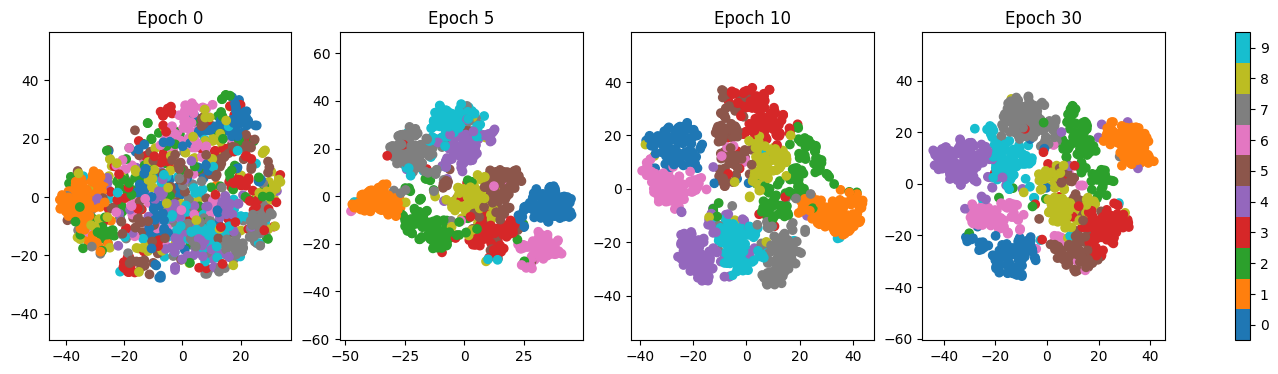

In [43]:
f, a = plt.subplots(ncols=4, figsize=(18,4))
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

As training progresses, it is very clear that the latent space develops clusters corresponding to each digit. And we can make some observations about the closeness of certain digits to each other. For example, it makes sense that 4 and 9 overlap.